In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Problem 1:

## Setup and Imports

In [2]:
import os
import re
import nltk
import string
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import warnings
import gensim
from gensim.models import Word2Vec


warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


LISA_DIR = '/content/drive/MyDrive/lisa'
DOC_DIR = LISA_DIR
QUERY_FILE = os.path.join(LISA_DIR, 'LISA.QUE')

RELEVANCE_FILE = os.path.join(LISA_DIR, 'LISARJ.NUM')

OUTPUT_SAMPLES_FILE = 'samples.txt'
N_COMPONENTS_LSI = 2
QUERIES_TO_PLOT = 10
K_VALUES = [5, 10, 20, 40]
W2V_VECTOR_SIZE = 100


try: nltk.data.find('corpora/stopwords');
except LookupError: nltk.download('stopwords', quiet=True);
try: nltk.data.find('tokenizers/punkt');
except LookupError: nltk.download('punkt', quiet=True);
try: nltk.data.find('tokenizers/punkt_tab');
except LookupError: nltk.download('punkt_tab', quiet=True);

stop_words = set(stopwords.words('english'))

print("Setup complete. NLTK resources checked/downloaded.")
print(f"LISA directory: {LISA_DIR}")
print(f"Using Relevance File: {RELEVANCE_FILE}")

Setup complete. NLTK resources checked/downloaded.
LISA directory: /content/drive/MyDrive/lisa
Using Relevance File: /content/drive/MyDrive/lisa/LISARJ.NUM


# Data Loading Functions

In [4]:
import re
import os

def load_documents(doc_dir):
    documents = {}
    print(f"Attempting to load documents from split files in: {doc_dir}")
    try: all_files = os.listdir(doc_dir)
    except Exception as e: print(f"ERROR listing directory {doc_dir}: {e}"); return {}

    split_files = []
    excluded_suffixes = ('.QUE', '.REL', '.NUM', '.txt', '.md', 'README') # Exclude more non-doc files
    for filename in all_files:
        if filename.startswith("LISA") and not filename.endswith(excluded_suffixes) and '.' in filename[4:]:
            split_files.append(filename)

    print(f"Identified {len(split_files)} potential document split files.")
    loaded_count = 0
    doc_delimiter_pattern = re.compile(r"Document\s+(\d+)")

    for filename in split_files:
        file_path = os.path.join(doc_dir, filename)
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f: content = f.read()
            matches = list(doc_delimiter_pattern.finditer(content))
            if not matches: continue
            for i, match in enumerate(matches):
                doc_id = int(match.group(1))
                start_index = match.end()
                end_index = matches[i+1].start() if i + 1 < len(matches) else len(content)
                doc_text = content[start_index:end_index].strip()
                if doc_text: documents[doc_id] = doc_text; loaded_count += 1
        except Exception as e: print(f"  Error processing split file {filename}: {e}")

    print(f"Successfully loaded {loaded_count} documents from {len(split_files)} split files.")
    if not documents: print("WARNING: No documents were extracted.")
    return {doc_id: documents[doc_id] for doc_id in sorted(documents.keys())}


def load_queries(query_file):
    queries = {}
    print(f"Loading queries from: {query_file}")
    try:
        with open(query_file, 'r', encoding='utf-8', errors='ignore') as f: content = f.read()
        parts = content.split('#')
        for part in parts:
            part = part.strip()
            if not part: continue
            lines = part.split('\n', 1)
            if len(lines) == 2 and lines[0].strip().isdigit():
                queries[int(lines[0].strip())] = lines[1].strip()
            elif len(lines) == 1 and lines[0].strip().isdigit(): # Handle query with ID only
                 queries[int(lines[0].strip())] = ""
    except FileNotFoundError: print(f"ERROR: Query file not found at {query_file}"); return {}
    except Exception as e: print(f"Error reading queries: {e}"); return {}
    print(f"Loaded {len(queries)} queries.")
    return queries


def load_relevance_lisarj(relevance_file):
    relevance = {}
    print(f"Loading relevance data from (LISARJ format): {relevance_file}")
    try:
        with open(relevance_file, 'r', encoding='utf-8', errors='ignore') as f:
            lines = f.readlines()
        loaded_count = 0
        for line_num, line in enumerate(lines):
            line = line.strip()
            if not line: continue
            parts = line.split()
            if not parts or not parts[0].isdigit() or len(parts) < 3:
                 continue
            try:
                query_id = int(parts[0])
                relevant_docs = set()
                for doc_id_str in parts[2:]:
                    if doc_id_str.isdigit():
                        relevant_docs.add(int(doc_id_str))
                if query_id in relevance: print(f"Warning: Duplicate relevance entry for Query {query_id}. Overwriting.")
                relevance[query_id] = relevant_docs
                loaded_count += 1
            except (ValueError, IndexError) as e:
                print(f"Warning: Could not parse line {line_num+1}: '{line}'. Error: {e}. Skipping.")
    except FileNotFoundError: print(f"ERROR: Relevance file not found at {relevance_file}"); return {}
    except Exception as e: print(f"Error reading relevance data: {e}"); return {}

    print(f"Loaded relevance judgments for {len(relevance)} queries from {os.path.basename(relevance_file)}.")
    # Check if we got 35 queries now
    if len(relevance) != 35:
        print(f"Warning: Expected 35 queries based on LISARJ.NUM format, but loaded {len(relevance)}.")
    return relevance


documents = load_documents(DOC_DIR)
queries = load_queries(QUERY_FILE)
relevance_data = load_relevance_lisarj(RELEVANCE_FILE)

queries_original = queries.copy()
print(f"\nTotal queries loaded initially: {len(queries_original)}")

# Identify which queries have relevance data
valid_query_ids_for_eval = sorted([qid for qid in queries_original.keys() if qid in relevance_data])
if relevance_data: print(f"Number of queries with relevance data (for evaluation): {len(valid_query_ids_for_eval)}")
else: print("No relevance data found; evaluation will be skipped.")


doc_ids = list(documents.keys())
doc_texts = list(documents.values())
query_ids = sorted(list(queries_original.keys()))
query_texts = [queries_original[qid] for qid in query_ids]
print(f"Processing all {len(query_ids)} queries.")

if not documents: raise ValueError("CRITICAL ERROR: No documents loaded.")
if not queries: raise ValueError("CRITICAL ERROR: No queries loaded.")
if not doc_ids or not doc_texts: raise ValueError("CRITICAL ERROR: Document lists are empty.")
if not query_ids or not query_texts: raise ValueError("CRITICAL ERROR: Query lists are empty.")

print("\nData loading and list preparation complete.")
print(f"Number of documents: {len(doc_ids)}")
print(f"Number of queries to process: {len(query_ids)}")
print(f"Number of queries with relevance data: {len(relevance_data)}")

Attempting to load documents from split files in: /content/drive/MyDrive/lisa
Identified 14 potential document split files.
Successfully loaded 6003 documents from 14 split files.
Loading queries from: /content/drive/MyDrive/lisa/LISA.QUE
Loaded 35 queries.
Loading relevance data from (LISARJ format): /content/drive/MyDrive/lisa/LISARJ.NUM
Loaded relevance judgments for 79 queries from LISARJ.NUM.

Total queries loaded initially: 35
Number of queries with relevance data (for evaluation): 35
Processing all 35 queries.

Data loading and list preparation complete.
Number of documents: 5999
Number of queries to process: 35
Number of queries with relevance data: 79


## Preprocessing Function and Application

In [5]:
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Lowercase
    text = text.lower()

    # 2. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 3. Remove punctuation
    text = re.sub(r'[' + re.escape(string.punctuation) + r']', ' ', text) # Replace punctuation with space

    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords and short tokens
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1] # Min length 2

    # 6. Join back into string for TF-IDF vectorizer
    return ' '.join(tokens)


print("\nPreprocessing documents...")
preprocessed_docs = [preprocess_text(doc) for doc in doc_texts]
print(f"Finished preprocessing {len(preprocessed_docs)} documents.")


print("Preprocessing queries...")
preprocessed_queries = [preprocess_text(query) for query in query_texts]
print(f"Finished preprocessing {len(preprocessed_queries)} queries.")


try:
    with open(OUTPUT_SAMPLES_FILE, 'w', encoding='utf-8') as f:
        f.write("--- Preprocessed Document 1 ---\n")
        f.write(f"Original ID: {doc_ids[0]}\n")
        f.write(preprocessed_docs[0])
        f.write("\n\n--- Preprocessed Document 2 ---\n")
        f.write(f"Original ID: {doc_ids[1]}\n")
        f.write(preprocessed_docs[1])
    print(f"\nSaved first 2 preprocessed documents to {OUTPUT_SAMPLES_FILE}")
except IndexError:
    print("\nWarning: Could not save samples, less than 2 documents loaded.")
except Exception as e:
    print(f"\nError saving samples: {e}")


print("\nSample Preprocessed Document (ID {}):\n{}".format(doc_ids[0], preprocessed_docs[0][:300] if preprocessed_docs else "N/A"))
print("\nSample Preprocessed Query (ID {}):\n{}".format(query_ids[0], preprocessed_queries[0][:300] if preprocessed_queries else "N/A"))


Preprocessing documents...
Finished preprocessing 5999 documents.
Preprocessing queries...
Finished preprocessing 35 queries.

Saved first 2 preprocessed documents to samples.txt

Sample Preprocessed Document (ID 1):
indian council library information services research training proposal consideration critically examines indian library scene management operation services libraries inefficient ineffective resulting grave misallocation underutilisation library resources little major research carried university libr

Sample Preprocessed Query (ID 1):
interested identification evaluation novel computer architectures instance increased parallelism simd mimd machines also interested information associative stores memories associative processors computer architectures associative processors associative stores associative memory


## Vocabulary Size

In [20]:
from nltk.tokenize import word_tokenize # Ensure import if running standalone

all_doc_text = " ".join(preprocessed_docs)
all_doc_tokens = word_tokenize(all_doc_text)
unique_doc_tokens = set(all_doc_tokens)
doc_vocab_size = len(unique_doc_tokens)
print(f"  - Unique terms in Documents only: {doc_vocab_size}")

all_query_text = " ".join(preprocessed_queries)
all_query_tokens = word_tokenize(all_query_text)
unique_query_tokens = set(all_query_tokens)
query_vocab_size = len(unique_query_tokens)
print(f"  - Unique terms in Queries only: {query_vocab_size}")

all_combined_text = " ".join(preprocessed_docs + preprocessed_queries)
all_combined_tokens = word_tokenize(all_combined_text)
unique_combined_tokens = set(all_combined_tokens)
combined_vocab_size = len(unique_combined_tokens)
print(f"  - Unique terms across Documents AND Queries combined: {combined_vocab_size}")

  - Unique terms in Documents only: 17503
  - Unique terms in Queries only: 516
  - Unique terms across Documents AND Queries combined: 17532


## TF-IDF Vectorization and Retrieval

In [7]:
print("\nCalculating TF-IDF vectors...")

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm='l2') # L2 norm is standard for cosine similarity

# Fit on documents and transform documents
doc_tfidf_matrix = vectorizer.fit_transform(preprocessed_docs)

# Transform queries using the *same* fitted vectorizer
query_tfidf_vectors = vectorizer.transform(preprocessed_queries)

print(f"TF-IDF Document Matrix Shape: {doc_tfidf_matrix.shape}")
print(f"TF-IDF Query Matrix Shape: {query_tfidf_vectors.shape}")

print("\nPerforming retrieval using Cosine Similarity...")
retrieved_results = {}

for i, query_vec in enumerate(query_tfidf_vectors):
    query_id = query_ids[i]
    retrieved_results[query_id] = {}
    similarities = cosine_similarity(query_vec, doc_tfidf_matrix).flatten()
    sorted_doc_indices = np.argsort(similarities)[::-1]

    for k in K_VALUES:
        top_k_indices = sorted_doc_indices[:k]
        top_k_doc_ids = [doc_ids[idx] for idx in top_k_indices]
        retrieved_results[query_id][k] = top_k_doc_ids

print("Retrieval complete.")

if 'retrieved_results' in locals() and retrieved_results:

    sorted_query_ids_display = sorted(retrieved_results.keys())

    for query_id in sorted_query_ids_display:
        print(f"\n===============================")
        print(f"=== Query {query_id} ===")
        query_text_display = queries.get(query_id, "QUERY TEXT NOT FOUND")
        print(f"Query Text (start): {query_text_display[:150]}...")
        print(f"-------------------------------")

        if query_id in retrieved_results:
            for k in K_VALUES:
                retrieved_docs_display = retrieved_results[query_id].get(k, [])
                print(f"  Top {k} retrieved document IDs: {retrieved_docs_display}")
        else:
            print(f"  No results found for Query {query_id}")

    print("\n===============================")
    print("--- End of Retrieval Results ---")

else:
    print("Retrieval results dictionary ('retrieved_results') not found or is empty.")
    print("Please ensure Cell 5 has been run successfully.")



Calculating TF-IDF vectors...
TF-IDF Document Matrix Shape: (5999, 17503)
TF-IDF Query Matrix Shape: (35, 17503)

Performing retrieval using Cosine Similarity...
Retrieval complete.

=== Query 1 ===
Query Text (start): I AM INTERESTED IN THE IDENTIFICATION AND EVALUATION OF NOVEL
COMPUTER ARCHITECTURES, FOR INSTANCE, INCREASED PARALLELISM, BOTH
IN SIMD AND MIMD MACHI...
-------------------------------
  Top 5 retrieved document IDs: [1896, 3396, 4751, 4899, 3446]
  Top 10 retrieved document IDs: [1896, 3396, 4751, 4899, 3446, 189, 447, 3483, 3279, 4926]
  Top 20 retrieved document IDs: [1896, 3396, 4751, 4899, 3446, 189, 447, 3483, 3279, 4926, 2484, 4212, 435, 1447, 936, 360, 5854, 655, 1939, 1956]
  Top 40 retrieved document IDs: [1896, 3396, 4751, 4899, 3446, 189, 447, 3483, 3279, 4926, 2484, 4212, 435, 1447, 936, 360, 5854, 655, 1939, 1956, 2963, 5147, 3788, 5943, 1443, 1925, 4170, 5780, 697, 4627, 1445, 2747, 1289, 3984, 2952, 3401, 5835, 1397, 187, 387]

=== Query 2 ===
Query Tex

## Evaluation Metrics


Evaluating TF-IDF retrieval performance...
Evaluating for K=5 using 35 queries...
Processed 35 queries, evaluated 35 queries with relevance data and results.

--- TF-IDF Metrics @ K=5 ---
Average Precision: 0.1143
Average Recall:    0.2286
Average F1-Score:  0.1448
Evaluating for K=10 using 35 queries...
Processed 35 queries, evaluated 35 queries with relevance data and results.

--- TF-IDF Metrics @ K=10 ---
Average Precision: 0.0943
Average Recall:    0.3310
Average F1-Score:  0.1423
Evaluating for K=20 using 35 queries...
Processed 35 queries, evaluated 35 queries with relevance data and results.

--- TF-IDF Metrics @ K=20 ---
Average Precision: 0.0614
Average Recall:    0.4119
Average F1-Score:  0.1051
Evaluating for K=40 using 35 queries...
Processed 35 queries, evaluated 35 queries with relevance data and results.

--- TF-IDF Metrics @ K=40 ---
Average Precision: 0.0393
Average Recall:    0.4976
Average F1-Score:  0.0722

Plotting TF-IDF metrics...


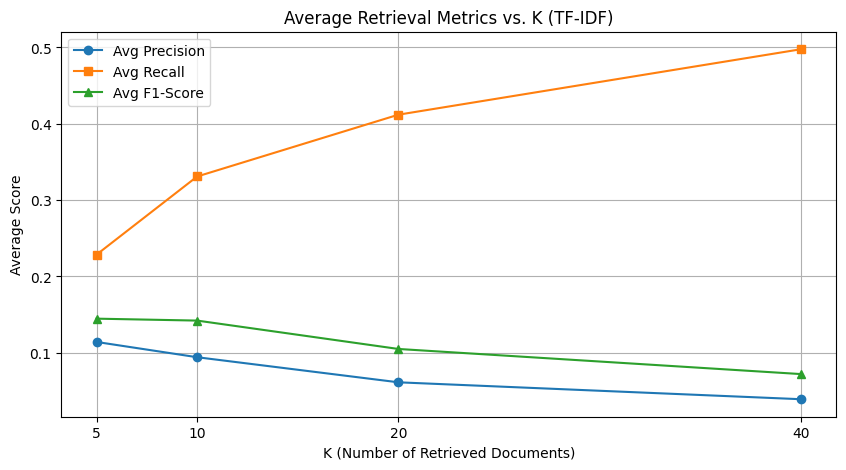

In [8]:
def calculate_precision(retrieved_ids, relevant_ids):
    retrieved_set = set(retrieved_ids)
    relevant_set = set(relevant_ids)
    true_positives = len(retrieved_set.intersection(relevant_set))
    return true_positives / len(retrieved_set) if retrieved_set else 0.0

def calculate_recall(retrieved_ids, relevant_ids):
    retrieved_set = set(retrieved_ids)
    relevant_set = set(relevant_ids)
    true_positives = len(retrieved_set.intersection(relevant_set))
    return true_positives / len(relevant_set) if relevant_set else 0.0

def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

print("\nEvaluating TF-IDF retrieval performance...")

average_metrics = {}

if 'relevance_data' not in locals() or not callable(calculate_precision):
     raise NameError("Relevance data or evaluation functions not found. Ensure Problem 1 cells were run.")
if 'retrieved_results' not in locals():
     raise NameError("TF-IDF retrieval results ('retrieved_results') not found. Ensure Cell 5 was run.")


for k in K_VALUES:
    all_precisions = []
    all_recalls = []
    all_f1s = []


    print(f"Evaluating for K={k} using {len(query_ids)} queries...")
    processed_count = 0
    evaluated_count = 0

    for query_id in query_ids:
        processed_count += 1
        if query_id not in relevance_data:
            continue

        if query_id not in retrieved_results:
             print(f"Error: Query {query_id} found in relevance data but MISSING from TF-IDF retrieval results! Skipping evaluation.")
             continue

        evaluated_count += 1
        relevant_docs = relevance_data[query_id]
        retrieved_docs_k = retrieved_results[query_id].get(k, [])

        precision_k = calculate_precision(retrieved_docs_k, relevant_docs)
        recall_k = calculate_recall(retrieved_docs_k, relevant_docs)
        f1_k = calculate_f1(precision_k, recall_k)

        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_f1s.append(f1_k)

    print(f"Processed {processed_count} queries, evaluated {evaluated_count} queries with relevance data and results.")

    avg_precision = np.mean(all_precisions) if all_precisions else 0.0
    avg_recall = np.mean(all_recalls) if all_recalls else 0.0
    avg_f1 = np.mean(all_f1s) if all_f1s else 0.0

    average_metrics[k] = {
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1
    }

    print(f"\n--- TF-IDF Metrics @ K={k} ---")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall:    {avg_recall:.4f}")
    print(f"Average F1-Score:  {avg_f1:.4f}")


print("\nPlotting TF-IDF metrics...")
if average_metrics:
    ks = list(average_metrics.keys())
    avg_ps = [average_metrics[k]['precision'] for k in ks]
    avg_rs = [average_metrics[k]['recall'] for k in ks]
    avg_f1s = [average_metrics[k]['f1'] for k in ks]

    plt.figure(figsize=(10, 5))
    plt.plot(ks, avg_ps, marker='o', label='Avg Precision')
    plt.plot(ks, avg_rs, marker='s', label='Avg Recall')
    plt.plot(ks, avg_f1s, marker='^', label='Avg F1-Score')
    plt.xlabel("K (Number of Retrieved Documents)")
    plt.ylabel("Average Score")
    plt.title("Average Retrieval Metrics vs. K (TF-IDF)")
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No TF-IDF metrics calculated to plot.")

## LSI Dimensionality Reduction and Visualization


Applying LSI (TruncatedSVD) to reduce dimensions to 2...
LSI Document Vector Shape: (5999, 2)
LSI Query Vector Shape: (35, 2)

Plotting 10 queries and their top 5 similar documents in 2D LSI space...


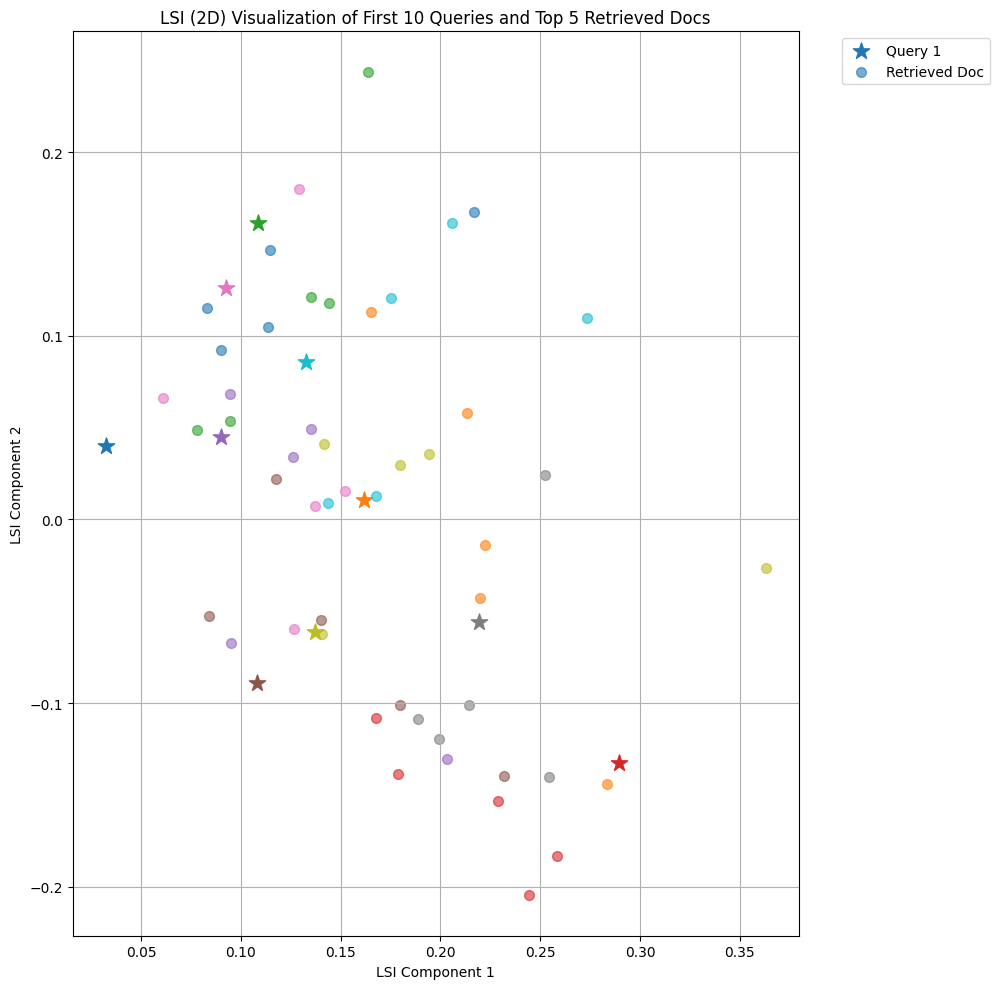


LSI plotting complete.


In [9]:
print(f"\nApplying LSI (TruncatedSVD) to reduce dimensions to {N_COMPONENTS_LSI}...")

svd = TruncatedSVD(n_components=N_COMPONENTS_LSI, random_state=42) # random_state for reproducibility
lsi_doc_vectors = svd.fit_transform(doc_tfidf_matrix)
lsi_query_vectors = svd.transform(query_tfidf_vectors)

print(f"LSI Document Vector Shape: {lsi_doc_vectors.shape}")
print(f"LSI Query Vector Shape: {lsi_query_vectors.shape}")


print(f"\nPlotting {QUERIES_TO_PLOT} queries and their top 5 similar documents in 2D LSI space...")
plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap('tab10', QUERIES_TO_PLOT)
plotted_doc_indices = set()
legend_handles = []


queries_to_plot_ids = query_ids[:QUERIES_TO_PLOT]
query_indices_to_plot = [query_ids.index(qid) for qid in queries_to_plot_ids] # Get list indices


for i, query_idx in enumerate(query_indices_to_plot):
    query_id = query_ids[query_idx]
    query_vec_2d = lsi_query_vectors[query_idx]
    color = colors(i)

    query_plot = plt.scatter(query_vec_2d[0], query_vec_2d[1], marker='*', s=150, color=color, label=f'Query {query_id}')
    if i == 0 : legend_handles.append(query_plot)

    if query_id in retrieved_results and 5 in retrieved_results[query_id]:
         top_5_doc_ids = retrieved_results[query_id][5]
    else:
         print(f"Warning: Could not get top 5 results for query {query_id} for plotting.")
         top_5_doc_ids = []


    doc_indices_to_plot = []
    for doc_id in top_5_doc_ids:
        try:
            doc_idx = doc_ids.index(doc_id)
            doc_indices_to_plot.append(doc_idx)
        except ValueError:
             print(f"Warning: Retrieved document {doc_id} not found in the original document list. Skipping plot.")
             pass

    for doc_idx in doc_indices_to_plot:
         if doc_idx < len(lsi_doc_vectors):
            doc_vec_2d = lsi_doc_vectors[doc_idx]
            doc_plot = plt.scatter(doc_vec_2d[0], doc_vec_2d[1], marker='o', s=50, color=color, alpha=0.6)
            plotted_doc_indices.add(doc_idx)
            if i == 0 and not any(h.get_label() == 'Retrieved Doc' for h in legend_handles):
                 doc_plot.set_label('Retrieved Doc')
                 legend_handles.append(doc_plot)

plt.title(f'LSI (2D) Visualization of First {QUERIES_TO_PLOT} Queries and Top 5 Retrieved Docs')
plt.xlabel('LSI Component 1')
plt.ylabel('LSI Component 2')
plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

print("\nLSI plotting complete.")

# Problem 2

In [10]:
!pip install --upgrade scipy gensim

  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)


## Training Skip-Gram

In [11]:
import gensim
from gensim.models import Word2Vec
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("Tokenizing preprocessed text for Word2Vec training...")
tokenized_docs = [doc.split() for doc in preprocessed_docs if doc]
tokenized_queries = [query.split() for query in preprocessed_queries if query]

training_corpus = tokenized_docs + tokenized_queries
print(f"Total sentences for Word2Vec training: {len(training_corpus)}")

if not training_corpus:
     raise ValueError("Cannot train Word2Vec model: Training corpus is empty. Check preprocessing.")


W2V_VECTOR_SIZE = 100 # As specified in the problem
W2V_WINDOW = 5       # Context window size
W2V_MIN_COUNT = 1    # Minimum word frequency
W2V_SG = 1           # 1 for Skip-Gram, 0 for CBOW
W2V_WORKERS = 4      # Number of CPU cores to use
W2V_EPOCHS = 20      # Number of training epochs

print(f"\nTraining Word2Vec Skip-Gram model...")
print(f"Parameters: vector_size={W2V_VECTOR_SIZE}, window={W2V_WINDOW}, min_count={W2V_MIN_COUNT}, sg={W2V_SG}, epochs={W2V_EPOCHS}")

word2vec_model = Word2Vec(sentences=training_corpus,
                          vector_size=W2V_VECTOR_SIZE,
                          window=W2V_WINDOW,
                          min_count=W2V_MIN_COUNT,
                          sg=W2V_SG,
                          workers=W2V_WORKERS,
                          epochs=W2V_EPOCHS)

print("Word2Vec model training complete.")
print(f"Vocabulary size: {len(word2vec_model.wv.key_to_index)}")

Tokenizing preprocessed text for Word2Vec training...
Total sentences for Word2Vec training: 6034

Training Word2Vec Skip-Gram model...
Parameters: vector_size=100, window=5, min_count=1, sg=1, epochs=20
Word2Vec model training complete.
Vocabulary size: 17532


## Creating Average Vectors


In [12]:
print("\nCreating average vectors for documents and queries...")

def get_average_vector(tokens, model, vector_size):
    """Calculates the average vector for a list of tokens."""
    vector_sum = np.zeros(vector_size)
    num_words = 0
    for word in tokens:
        if word in model.wv:
            vector_sum += model.wv[word]
            num_words += 1

    if num_words > 0:
        return vector_sum / num_words
    else:
        return np.zeros(vector_size)

# Calculate average vectors for documents
doc_vectors_w2v = np.array([get_average_vector(tokens, word2vec_model, W2V_VECTOR_SIZE) for tokens in tokenized_docs])

# Calculate average vectors for queries
query_vectors_w2v = np.array([get_average_vector(tokens, word2vec_model, W2V_VECTOR_SIZE) for tokens in tokenized_queries])

print(f"Shape of document vectors (Word2Vec): {doc_vectors_w2v.shape}")
print(f"Shape of query vectors (Word2Vec): {query_vectors_w2v.shape}")

if doc_vectors_w2v.shape[0] != len(doc_ids):
     print(f"Warning: Number of document vectors ({doc_vectors_w2v.shape[0]}) doesn't match number of doc_ids ({len(doc_ids)})")
if query_vectors_w2v.shape[0] != len(query_ids):
     print(f"Warning: Number of query vectors ({query_vectors_w2v.shape[0]}) doesn't match number of query_ids ({len(query_ids)})")


Creating average vectors for documents and queries...
Shape of document vectors (Word2Vec): (5999, 100)
Shape of query vectors (Word2Vec): (35, 100)


## Information Retrieval using Word2Vec Vectors

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

print("\nPerforming retrieval using Word2Vec average vectors and Cosine Similarity...")

retrieved_results_w2v = {}

if doc_vectors_w2v.size == 0 or query_vectors_w2v.size == 0:
    raise ValueError("Word2Vec document or query vectors are empty. Cannot perform retrieval.")


if len(query_vectors_w2v.shape) == 1: query_vectors_w2v = query_vectors_w2v.reshape(1, -1)
if len(doc_vectors_w2v.shape) == 1: doc_vectors_w2v = doc_vectors_w2v.reshape(1, -1)

similarities_w2v = cosine_similarity(query_vectors_w2v, doc_vectors_w2v)
print(f"Similarity matrix shape: {similarities_w2v.shape}")


for i, query_id in enumerate(query_ids):
    retrieved_results_w2v[query_id] = {}

    query_similarities = similarities_w2v[i]

    query_similarities = np.nan_to_num(query_similarities, nan=-1.0)
    sorted_doc_indices = np.argsort(query_similarities)[::-1]

    for k in K_VALUES:
        top_k_indices = sorted_doc_indices[:k]
        top_k_doc_ids = [doc_ids[idx] for idx in top_k_indices]
        retrieved_results_w2v[query_id][k] = top_k_doc_ids

print("Word2Vec retrieval complete.")

sample_query_id_w2v = query_ids[0] if query_ids else None
if sample_query_id_w2v:
    print(f"\nSample Word2Vec retrieved documents for Query {sample_query_id_w2v} (Top 5):")
    if sample_query_id_w2v in retrieved_results_w2v and 5 in retrieved_results_w2v[sample_query_id_w2v]:
        print(retrieved_results_w2v[sample_query_id_w2v][5])
    else:
        print("Results not available for sample query.")

print("\n--- Word2Vec Retrieval Results (Average Vectors) ---")


sorted_query_ids_display_w2v = sorted(retrieved_results_w2v.keys())

for query_id in query_ids:
  print(f"\n===============================")
  print(f"=== Query {query_id} ===")

  if 'queries_original' in locals():
      query_text_display = queries_original.get(query_id, "QUERY TEXT NOT FOUND")
      print(f"Query Text (start): {query_text_display[:150]}...")
  else:
      print("Original query text dictionary not found.")
  print(f"-------------------------------")

  if query_id in retrieved_results_w2v:
      for k in K_VALUES:
          retrieved_docs_display_w2v = retrieved_results_w2v[query_id].get(k, [])

          print(f"  Top {k} retrieved document IDs: {retrieved_docs_display_w2v}")
  else:
      print(f"  WARNING: No Word2Vec results found for Query {query_id}")

print("\n===============================")
print("--- End of Word2Vec Retrieval Results ---")




Performing retrieval using Word2Vec average vectors and Cosine Similarity...
Similarity matrix shape: (35, 5999)
Word2Vec retrieval complete.

Sample Word2Vec retrieved documents for Query 1 (Top 5):
[2933, 435, 3265, 1444, 3396]

--- Word2Vec Retrieval Results (Average Vectors) ---

=== Query 1 ===
Query Text (start): I AM INTERESTED IN THE IDENTIFICATION AND EVALUATION OF NOVEL
COMPUTER ARCHITECTURES, FOR INSTANCE, INCREASED PARALLELISM, BOTH
IN SIMD AND MIMD MACHI...
-------------------------------
  Top 5 retrieved document IDs: [2933, 435, 3265, 1444, 3396]
  Top 10 retrieved document IDs: [2933, 435, 3265, 1444, 3396, 3945, 2787, 1442, 3941, 2932]
  Top 20 retrieved document IDs: [2933, 435, 3265, 1444, 3396, 3945, 2787, 1442, 3941, 2932, 936, 2504, 4427, 1397, 3801, 4367, 3392, 187, 1423, 2908]
  Top 40 retrieved document IDs: [2933, 435, 3265, 1444, 3396, 3945, 2787, 1442, 3941, 2932, 936, 2504, 4427, 1397, 3801, 4367, 3392, 187, 1423, 2908, 5146, 1445, 2906, 3405, 5382, 5147,

## Evaluate Word2Vec Results and Compare with TF-IDF


Evaluating Word2Vec retrieval performance...

--- Word2Vec Metrics @ K=5 ---
Average Precision: 0.0857
Average Recall:    0.1643
Average F1-Score:  0.1080

--- Word2Vec Metrics @ K=10 ---
Average Precision: 0.0743
Average Recall:    0.2500
Average F1-Score:  0.1116

--- Word2Vec Metrics @ K=20 ---
Average Precision: 0.0629
Average Recall:    0.3952
Average F1-Score:  0.1070

--- Word2Vec Metrics @ K=40 ---
Average Precision: 0.0407
Average Recall:    0.4976
Average F1-Score:  0.0748

--- Comparison: TF-IDF vs Word2Vec ---


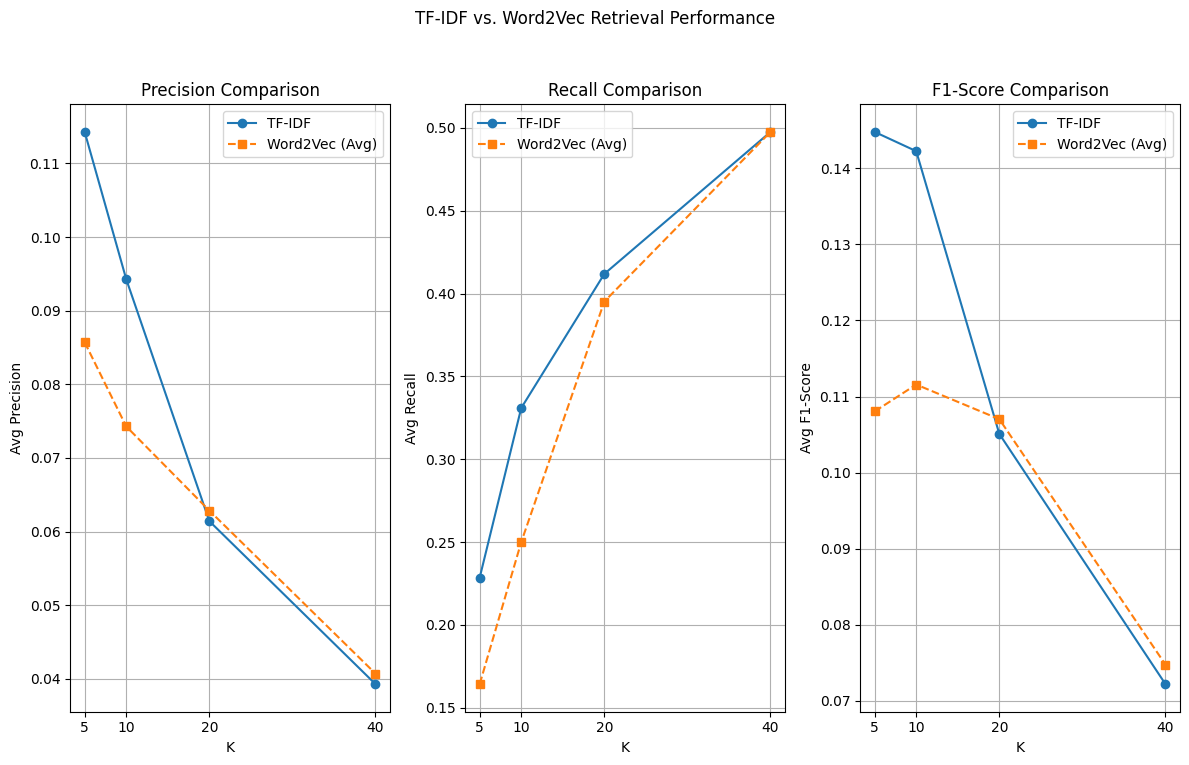


Metric Summary Table:
K   | Metric    | TF-IDF  | Word2Vec
----|-----------|---------|----------
5   | Precision | 0.1143  | 0.0857  
5   | Recall    | 0.2286  | 0.1643  
5   | F1-Score  | 0.1448  | 0.1080  
----|-----------|---------|----------
10  | Precision | 0.0943  | 0.0743  
10  | Recall    | 0.3310  | 0.2500  
10  | F1-Score  | 0.1423  | 0.1116  
----|-----------|---------|----------
20  | Precision | 0.0614  | 0.0629  
20  | Recall    | 0.4119  | 0.3952  
20  | F1-Score  | 0.1051  | 0.1070  
----|-----------|---------|----------
40  | Precision | 0.0393  | 0.0407  
40  | Recall    | 0.4976  | 0.4976  
40  | F1-Score  | 0.0722  | 0.0748  


In [19]:
import matplotlib.pyplot as plt

print("\nEvaluating Word2Vec retrieval performance...")

average_metrics_w2v = {}

for k in K_VALUES:
    all_precisions_w2v = []
    all_recalls_w2v = []
    all_f1s_w2v = []

    for query_id in query_ids:
        if query_id not in relevance_data:
            continue
        if not relevance_data[query_id]:
             pass


        retrieved_docs_k_w2v = retrieved_results_w2v.get(query_id, {}).get(k, [])
        relevant_docs = relevance_data[query_id]

        precision_k = calculate_precision(retrieved_docs_k_w2v, relevant_docs)
        recall_k = calculate_recall(retrieved_docs_k_w2v, relevant_docs)
        f1_k = calculate_f1(precision_k, recall_k)

        all_precisions_w2v.append(precision_k)
        all_recalls_w2v.append(recall_k)
        all_f1s_w2v.append(f1_k)

    avg_precision_w2v = np.mean(all_precisions_w2v) if all_precisions_w2v else 0.0
    avg_recall_w2v = np.mean(all_recalls_w2v) if all_recalls_w2v else 0.0
    avg_f1_w2v = np.mean(all_f1s_w2v) if all_f1s_w2v else 0.0

    average_metrics_w2v[k] = {
        'precision': avg_precision_w2v,
        'recall': avg_recall_w2v,
        'f1': avg_f1_w2v
    }

    print(f"\n--- Word2Vec Metrics @ K={k} ---")
    print(f"Average Precision: {avg_precision_w2v:.4f}")
    print(f"Average Recall:    {avg_recall_w2v:.4f}")
    print(f"Average F1-Score:  {avg_f1_w2v:.4f}")


print("\n--- Comparison: TF-IDF vs Word2Vec ---")

if 'average_metrics' not in locals():
    print("Warning: TF-IDF metrics not found.")
else:
    ks = list(average_metrics.keys())
    avg_ps_tfidf = [average_metrics[k]['precision'] for k in ks]
    avg_rs_tfidf = [average_metrics[k]['recall'] for k in ks]
    avg_f1s_tfidf = [average_metrics[k]['f1'] for k in ks]

    avg_ps_w2v = [average_metrics_w2v[k]['precision'] for k in ks]
    avg_rs_w2v = [average_metrics_w2v[k]['recall'] for k in ks]
    avg_f1s_w2v = [average_metrics_w2v[k]['f1'] for k in ks]


    plt.figure(figsize=(12, 8))

    # Precision Plot
    plt.subplot(1, 3, 1)
    plt.plot(ks, avg_ps_tfidf, marker='o', linestyle='-', label='TF-IDF')
    plt.plot(ks, avg_ps_w2v, marker='s', linestyle='--', label='Word2Vec (Avg)')
    plt.xlabel("K")
    plt.ylabel("Avg Precision")
    plt.title("Precision Comparison")
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)

    # Recall Plot
    plt.subplot(1, 3, 2)
    plt.plot(ks, avg_rs_tfidf, marker='o', linestyle='-', label='TF-IDF')
    plt.plot(ks, avg_rs_w2v, marker='s', linestyle='--', label='Word2Vec (Avg)')
    plt.xlabel("K")
    plt.ylabel("Avg Recall")
    plt.title("Recall Comparison")
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)

    # F1-Score Plot
    plt.subplot(1, 3, 3)
    plt.plot(ks, avg_f1s_tfidf, marker='o', linestyle='-', label='TF-IDF')
    plt.plot(ks, avg_f1s_w2v, marker='s', linestyle='--', label='Word2Vec (Avg)')
    plt.xlabel("K")
    plt.ylabel("Avg F1-Score")
    plt.title("F1-Score Comparison")
    plt.xticks(ks)
    plt.legend()
    plt.grid(True)

    plt.suptitle('TF-IDF vs. Word2Vec Retrieval Performance')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    print("\nMetric Summary Table:")
    print("K   | Metric    | TF-IDF  | Word2Vec")
    print("----|-----------|---------|----------")
    for k in ks:
        print(f"{k:<4}| Precision | {avg_ps_tfidf[ks.index(k)]:<7.4f} | {avg_ps_w2v[ks.index(k)]:<8.4f}")
        print(f"{k:<4}| Recall    | {avg_rs_tfidf[ks.index(k)]:<7.4f} | {avg_rs_w2v[ks.index(k)]:<8.4f}")
        print(f"{k:<4}| F1-Score  | {avg_f1s_tfidf[ks.index(k)]:<7.4f} | {avg_f1s_w2v[ks.index(k)]:<8.4f}")
        if k != ks[-1]: print("----|-----------|---------|----------")